In [1]:
%matplotlib inline
from importlib import reload
import os
import pandas as pd
import sys
sys.path.append('D:/MicroMator/AnalysisTools')
import AnalysisTools as at
reload(at)
import matplotlib.pyplot as plt
import numpy as np

### Load the raw analyzed data, mean channel data & buckets, sort & filter the raw data (sort by bucket and remove unwanted cells)

In [2]:
pos_list = [0]
legend_buckets = []
list_channels = ['RHOD-DIRECT']
frames = 150

In [3]:
track_csvs = []

exp_path = 'Z:\\Microscope_experiments\\AchilleFraisse\\2020-11-12_mpc_fsp_control\\'
track_csvs.append(pd.read_csv(exp_path+'\\Analysis\\SegMator\\pos0\\track.csv', index_col=[0], low_memory=False))


In [4]:
#params
maxframe = frames
framenum = 50
realmaxframe = maxframe-framenum
DMDborder = 75
imageborders = (0, 1024)

clean_track_csvs = []
for df in track_csvs:
    ##SORT unusable frames
    newdf = at.clean_maxframe(df, maxframe)
    #newdf = newdf.loc[newdf.frame < realmaxframe]

    ##SORT blips (cells present less than x frames)µ
    newdf = at.clean_blips(newdf)

    ##SORT cells not in DMD border
    newdf = at.clean_DMDborder(newdf)

    ##SORT cut cells
    newdf = at.clean_borders(newdf, imageborders, 20)
    
    ##SORT major area changes
    newdf = at.clean_cellswitch(newdf, 'area', 100)
    
    ##SORT major RHOD-DIRECT changes
    #newdf = at.clean_cellswitch(newdf, 'RHOD-DIRECT mean', 300)
    
    clean_track_csvs.append(newdf)
    
    
print('cleaned csvs')

cleaned csvs


### calculate cells numbers per frame

In [5]:
cells_per_frame = []
results = []
for index, single_df in enumerate(track_csvs):
    cells_per_frame.append(at.get_n_cells_per_frame(single_df))
    
print('extracted cells numbers per frame')

extracted cells numbers per frame


Growth rate pos 0: 0.006836564262819872 [1/min]


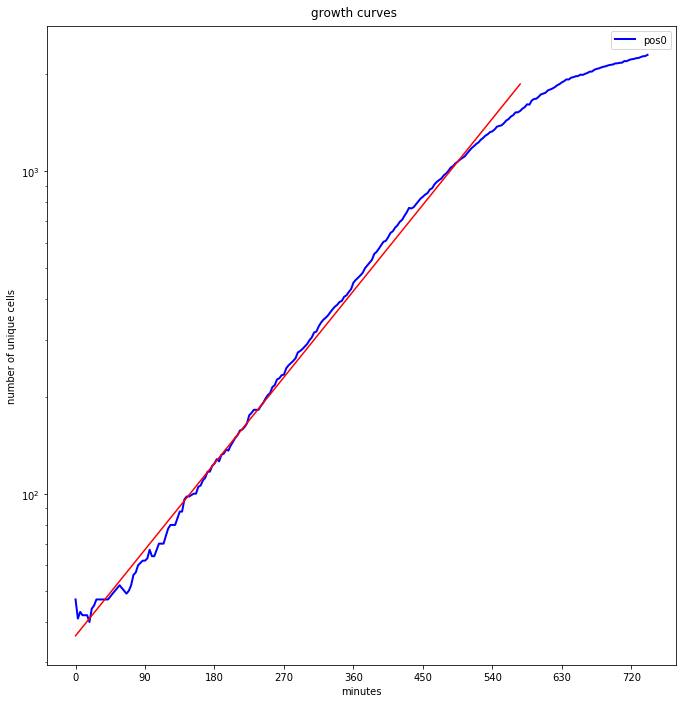

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
fig.tight_layout(pad=3.0)
fig.suptitle('growth curves')

ylab = 'number of unique cells'
xlab = 'minutes'
legend = ['pos0', 'pos1', 'pos2']
ax.set_yscale('log')
at.simpleline_plot(cells_per_frame[0], ax, '', 'b', legend[0], ylab, xlab)


start=0; cutoff=193; times = np.arange(start,cutoff)*3;
p = np.polyfit(times, np.log(cells_per_frame[0][start:cutoff]),1)
ax.plot(times, np.exp(p[1])*np.exp(times*p[0]),color='r')
print('Growth rate pos {0}: {1} [1/min]'.format(0,p[0]))

Text(0.5, 1, 'fluorescence trajectories of all cells')

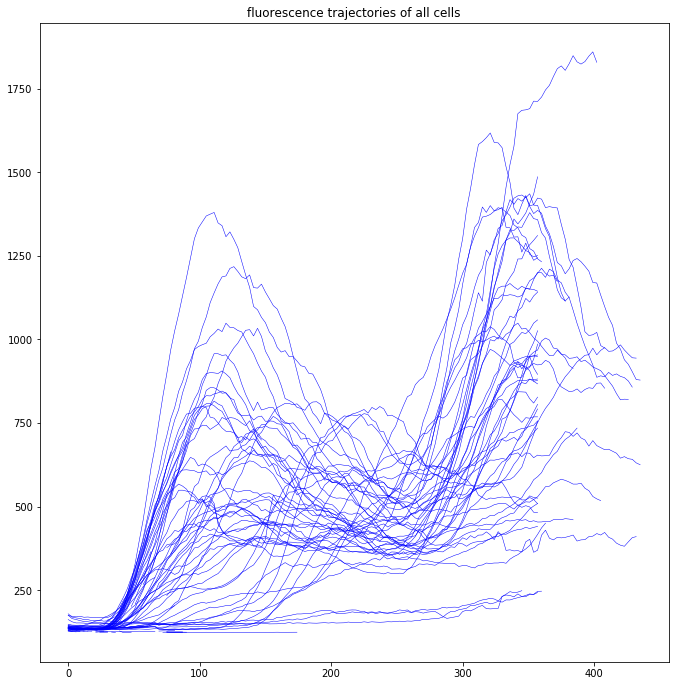

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
fig.tight_layout(pad=3.0)

ylab = 'mean pixels'
xlab = 'minutes'

for index, cell in enumerate(track_csvs[0].particle.unique()[:100]):
        ax.plot(track_csvs[0].loc[track_csvs[0].particle == cell]['frame'][:120]*3, track_csvs[0].loc[track_csvs[0].particle == cell]['RHOD-DIRECT mean'][:120], c='b', linewidth=0.5)
ax.set_title("fluorescence trajectories of all cells")

### Model Predictive Control analysis This part requires the Stoched repository

In [8]:
import dill
import sys
sys.path.append('../../../../../')
import stoched
from importlib import reload
reload(stoched)

with open(exp_path +os.path.join('Models','pos0_all_mpcs.pickle'), 'rb') as f:
    all_mpcs=dill.load(f)
    

In [14]:

mpc = all_mpcs[50]
from ipywidgets import interact, widgets



f = plt.figure(figsize=(8,4))
ax = f.add_axes([0.2,0.3,.8,.45])
ax2 = f.add_axes([.25, .8, .7, .1 ])

def update(mpc_id):
    ax.clear()
    mpc = all_mpcs[mpc_id]
    print(mpc.particle_id)
    tvec = mpc.period*(np.arange(len(mpc.all_measurements))+mpc.initial_iteration)
    tvec_targ = np.arange(len(mpc.full_target))*mpc.period
    full_target_fluor = mpc.full_target*mpc.mu_rfp

    ax.plot(tvec_targ,full_target_fluor,'k--')
    ax.plot(tvec,mpc.all_measurements,'indianred')
    # ax.plot(tvec_targ,full_target,'k--')
    # ax.plot(tvec,all_states[:,1],'indianred')
    # ax.set_ylim([0,300])
    ax.set_xlabel('time [min]')
    ax.set_ylabel('a.f.u.')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_ylim([0,1500])


    ax2.imshow(np.atleast_2d(mpc.full_control_vector), cmap='Blues', aspect='auto', vmin=0, vmax=3)
    ax2.set_yticks([])
    ax2.set_yticklabels([])
    
interact(update, mpc_id=widgets.IntSlider(min=0, max=len(all_mpcs), step=1, value=0))

0


<function __main__.update(mpc_id)>

### Script to produce the panel 2D of the micromator paper

d:\miniconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice


Text(0, 0.5, 'a.f.u.')

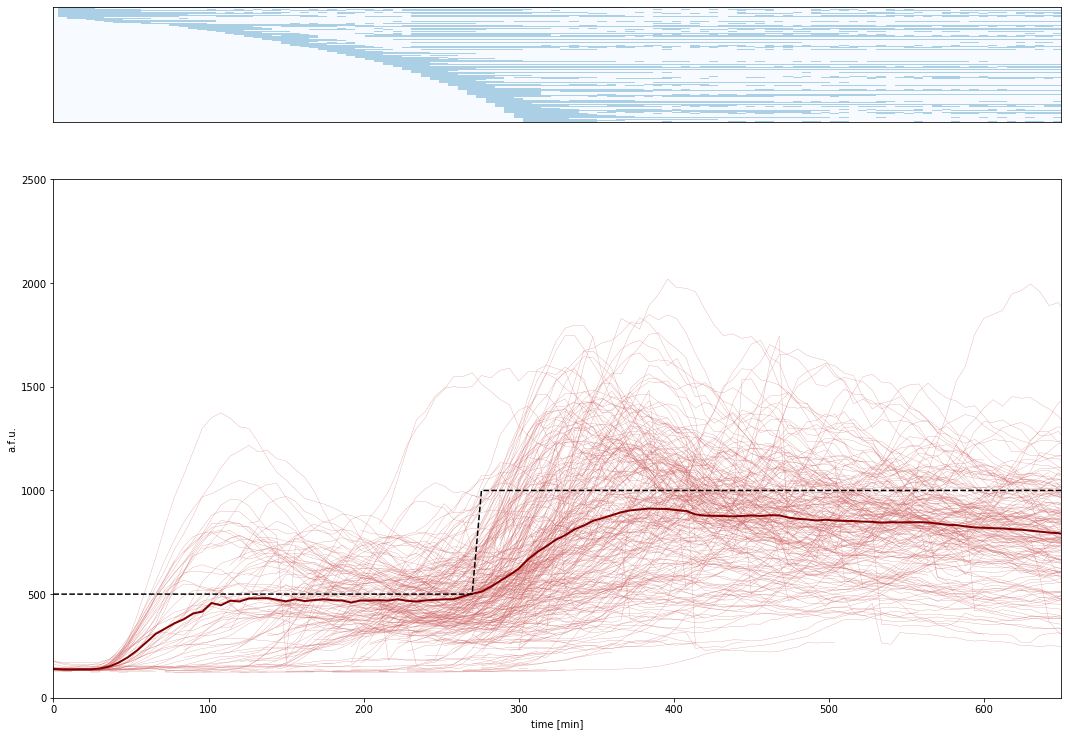

In [9]:
# parse the data into a matrix
all_data = np.zeros( (len(all_mpcs), len(all_mpcs[0].full_target)) )
all_light_signals = np.zeros( (len(all_mpcs), len(all_mpcs[0].full_control_vector)) )
for i,mpc in enumerate(all_mpcs.values()):
    if (len(mpc.all_measurements)>20) & mpc.initial_iteration<30:
        all_data[i,mpc.initial_iteration:mpc.initial_iteration+len(mpc.all_measurements)] = mpc.all_measurements + np.ones(len(mpc.all_measurements))*120
        all_light_signals[i,:] = mpc.full_control_vector
        
    
all_data[all_data==0] = np.nan
f = plt.figure(figsize=(20,16))
ax = f.add_axes([0.2,0.3,.7,.45])
ax2 = f.add_axes([.2, .8, .7, .1 ])
tvec = mpc.period*np.arange(all_data.shape[1])
full_target_fluor = mpc.full_target*mpc.mu_rfp
ax.plot(tvec, all_data.T, color='indianred', linewidth=0.2)
ax.plot(tvec, np.nanmean(all_data,axis=0),color='maroon',linewidth=2)
ax.plot(tvec, full_target_fluor,'k--')
ax2.imshow(all_light_signals, cmap='Blues', aspect='auto', vmin=0, vmax=3)
ax2.set_yticks([])
ax2.set_yticklabels([])
ax2.set_xticks([])
ax2.set_xticklabels([])
ax.set_xlim([0,650])
ax2.set_xlim([0,650/6])
# ax.set_ylim([0,4000])
ax.set_ylim([0,2500])


ax.set_xlabel('time [min]')
ax.set_ylabel('a.f.u.')
